In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings

In [3]:
df=pd.read_csv('PCOS_infertility.csv')
df2 = pd.read_excel('PCOS_data_without_infertility.xlsx',sheet_name="Full_new")

In [4]:
data = pd.merge(df2,df,how = 'left')
data = data.drop(["Sl. No","Patient File No.","Unnamed: 44"],axis = 1)
data = data.rename(columns = {"PCOS (Y/N)":"Target"})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Target                  541 non-null    int64  
 1    Age (yrs)              541 non-null    int64  
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   BMI                     541 non-null    float64
 5   Blood Group             541 non-null    int64  
 6   Pulse rate(bpm)         541 non-null    int64  
 7   RR (breaths/min)        541 non-null    int64  
 8   Hb(g/dl)                541 non-null    float64
 9   Cycle(R/I)              541 non-null    int64  
 10  Cycle length(days)      541 non-null    int64  
 11  Marraige Status (Yrs)   540 non-null    float64
 12  Pregnant(Y/N)           541 non-null    int64  
 13  No. of aborptions       541 non-null    int64  
 14    I   beta-HCG(mIU/mL)  541 non-null    fl

In [5]:
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')


In [6]:
data.columns[data.isnull().any()]

Index(['Marraige Status (Yrs)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)',
       'Fast food (Y/N)'],
      dtype='object')

In [7]:
data['Marraige Status (Yrs)'] = data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median())
data['II    beta-HCG(mIU/mL)'] = data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median())
data['AMH(ng/mL)'] = data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median())
data['Fast food (Y/N)'] = data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median())

In [8]:
data.isnull().sum()

Target                    0
 Age (yrs)                0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     0
Pregnant(Y/N)             0
No. of aborptions         0
  I   beta-HCG(mIU/mL)    0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           0
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg) 

In [9]:
data.describe()

,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [10]:
X= data.drop(labels = ["Target"],axis = 1)
y= data.Target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
classifiers = [CatBoostClassifier(),RandomForestClassifier(), DecisionTreeClassifier(),  LogisticRegression(), KNeighborsClassifier(), XGBClassifier()]
classifiers_names = ['CatBoostClassifier','RandomForestClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'XGBClassifier']

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

logreg_param_grid = {'solver': ['newton-cg', 'lbfgs'],
                    "C":np.logspace(-3,3,7),}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

CB_param_grid = {"verbose": [0]}

XGB_param_grid = {'max_depth' : [3]}

classifiers_param = [CB_param_grid, rf_param_grid, dt_param_grid, logreg_param_grid, knn_param_grid, XGB_param_grid]

In [17]:
warnings.filterwarnings('ignore') 
classifiers_scores = []
best_estimators = []
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

for i in range(len(classifiers)):
    est = GridSearchCV(estimator = classifiers[i], param_grid = classifiers_param[i], scoring ='accuracy', cv = 5,verbose=0)
    est.fit(X_train, y_train)
    classifiers_scores.append(est.best_score_)
    best_estimators.append(est.best_estimator_)

classifiers_df = pd.DataFrame({'Classifier': classifiers_names, 'Score': classifiers_scores})
classifiers_df

,Classifier,Score
0,CatBoostClassifier,0.893585
1,RandomForestClassifier,0.916760
2,DecisionTreeClassifier,0.875007
3,LogisticRegression,0.877493
4,KNeighborsClassifier,0.750120
5,XGBClassifier,0.875167


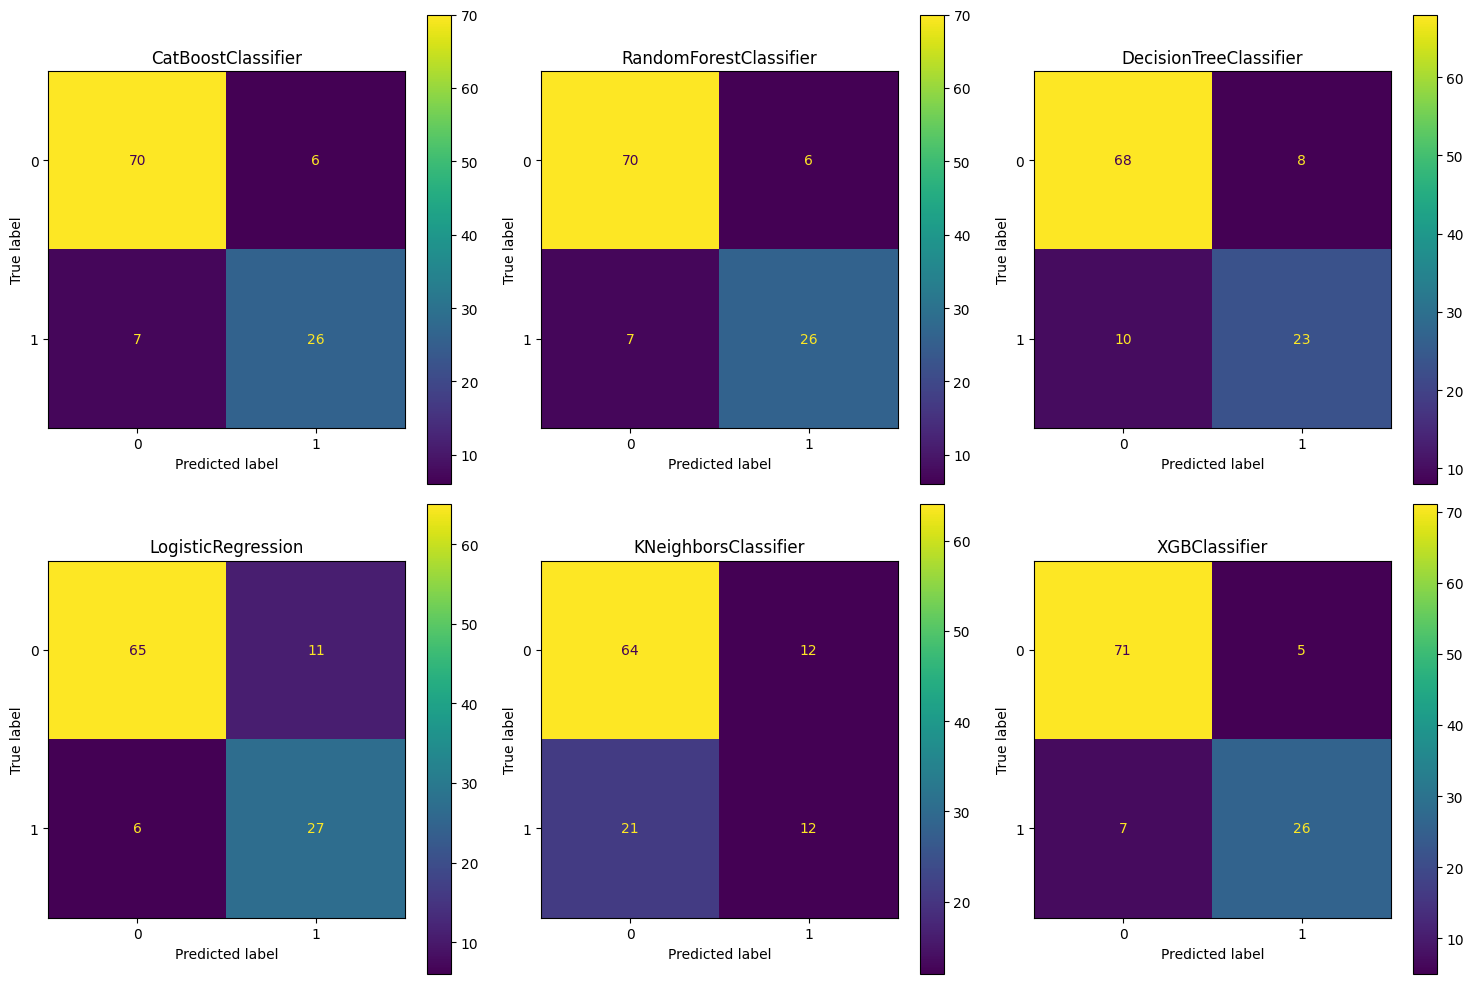

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for cls, ax in zip(best_estimators, axes.flatten()):
    pred=cls.predict(X_test)
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(ax=ax)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()